In [34]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from skimage import feature
from skimage.feature import graycomatrix, graycoprops
from skimage import io, color, img_as_ubyte
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, f1_score, recall_score, precision_score
from sklearn.decomposition import PCA

## Feature Extraction

### Local Binary Pattern

In [35]:
def read_images_from_folder(folder_path):
    images = []
    labels = []

    for subfolder in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder)
        if os.path.isdir(subfolder_path):
            label = subfolder  # Use the subfolder name as the label
            for fn in os.listdir(subfolder_path):
                if fn.endswith('.jpg'):
                    img_path = os.path.join(subfolder_path, fn)
                    im = Image.open(img_path).convert('L')
                    data = np.array(im)
                    images.append(data)
                    labels.append(label)

    return images, labels

# Load images and labels from the 'resize_data' 
data_folder = './resize_data'
images, labels = read_images_from_folder(data_folder)
print('Load data success!')

X = np.array(images)
print(X.shape)

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

radius = 2
n_point = radius * 8

Load data success!
(1790, 256, 256)
(1432, 256, 256)
(358, 256, 256)
(1432,)
(358,)


In [36]:
def lbp_texture(train_data, test_data):
    max_bins_train = 0
    max_bins_test = 0

    for i in range(len(train_data)):
        lbp = feature.local_binary_pattern(train_data[i], n_point, radius, 'default')
        max_bins_train = max(max_bins_train, int(lbp.max()) + 1)

    for i in range(len(test_data)):
        lbp = feature.local_binary_pattern(test_data[i], n_point, radius, 'default')
        max_bins_test = max(max_bins_test, int(lbp.max()) + 1)

    train_hist = np.zeros((len(train_data), max_bins_train))
    test_hist = np.zeros((len(test_data), max_bins_test))

    for i in range(len(train_data)):
        lbp = feature.local_binary_pattern(train_data[i], n_point, radius, 'default')
        train_hist[i], _ = np.histogram(lbp, bins=max_bins_train, density=True)

    for i in range(len(test_data)):
        lbp = feature.local_binary_pattern(test_data[i], n_point, radius, 'default')
        test_hist[i], _ = np.histogram(lbp, bins=max_bins_test, density=True)

    return train_hist, test_hist


In [37]:
X_train, X_test = lbp_texture(X_train, X_test)

# Create and train an MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=200)
mlp.fit(X_train, y_train)

# Predict on the test set
y_pred = mlp.predict(X_test)

# Evaluate the MLP classifier
train_accuracy = mlp.score(X_train, y_train)
test_accuracy = mlp.score(X_test, y_test)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
classify_report = classification_report(y_test, y_pred)


print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"\nOverall Accuracy: {classify_report}")

# Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Plot the loss and accuracy curves during training
plt.figure(figsize=(10, 5))

# Plot the training loss curve
plt.subplot(1, 2, 1)
plt.plot(mlp.loss_curve_)
plt.title('MLP Training Loss Curve')
plt.xlabel('Iteration')
plt.ylabel('Loss')

# Bar chart for accuracy
plt.subplot(1, 2, 2)
labels = ['Training Accuracy', 'Test Accuracy']
accuracy_values = [mlp.score(X_train, y_train), mlp.score(X_test, y_test)]
plt.bar(labels, accuracy_values, color=['blue', 'orange'])
plt.ylabel('Accuracy')
plt.ylim(0, 1)

plt.suptitle('MLP Training Loss Curve and Test Accuracy')

plt.savefig('LBP_mlp_training_curve.png')

plt.show()

KeyboardInterrupt: 

In [ ]:
# Save the trained MLP model to a file
model_filename = './model/mlp_lbp_model.pkl'
joblib.dump(mlp, model_filename)

print(f"MLP model saved as {model_filename}")

MLP model saved as ./model/mlp_lbp_model.pkl


### Convolutional Neural Network

In [8]:
# System
import pathlib
import glob
import os, os.path, shutil
# Data Exploration
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import pandas as pd
import seaborn as sns
from PIL import Image
# Machine Learning
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
#Deep Learning
import tensorflow as tf
import keras
from keras.utils import plot_model ######
from keras import backend as K ##########
from keras import metrics
from keras.regularizers import l2,l1
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, InputLayer, Activation
from keras.preprocessing.image import img_to_array, ImageDataGenerator, array_to_img, load_img
from keras.metrics import AUC
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint
# Something unknown :)
import pydot
from dask import bag,  diagnostics
from mlxtend.plotting import plot_confusion_matrix

In [61]:
def create_charts(cnn, cnn_model):
    """
    plot1: train & validatoin loss curves
    plot2: train & validatoin accuracy curves
    Plot3: confusion matrix
    Plot4: train & validation ROC curve and AUC score
    Summary Statistics
    
    """
    
    ## Define train & validation loss
    train_loss = cnn_model.history['loss']
    val_loss = cnn_model.history['val_loss']
    
    ## Define train & validation accuracy
    train_auc = cnn_model.history['accuracy']
    val_auc = cnn_model.history['val_acc']
    
    ## Define y_pred & y_true
    y_true = test_generator.classes
    Y_pred = cnn.predict_generator(test_generator, steps = len(test_generator))
    y_pred = (Y_pred > 0.5).T[0]
    y_pred_prob = Y_pred.T[0]
    
    ## PLOT ##
    fig = plt.figure(figsize=(13, 10))
    
    ## PLOT 1: TRAIN VS. VALIDATION LOSS 
    plt.subplot(2,2,1)
    plt.title("Training vs. Validation Loss")
    plt.plot(train_loss, label='training loss')
    plt.plot(val_loss, label='validation loss')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()

    ## PLOT 2: TRAIN VS. VALIDATION Accuracy
    plt.subplot(2,2,2)
    plt.title("Training vs. Validation AUC Score")
    plt.plot(train_auc, label='training auc')
    plt.plot(val_auc, label='validation auc')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()
    
    ## PLOT 3: CONFUSION MATRIX
    plt.subplot(2,2,3)
    # Set up the labels for in the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
  
    names = ['True Positives', 'False Negatives', 'False Positives', 'True Negatives']
    counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)
    ticklabels = ['CORROSION', 'NOCORROSION']

      # Create confusion matrix as heatmap
    sns.set(font_scale = 1.4)
    ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Oranges', xticklabels=ticklabels, yticklabels=ticklabels )
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.title("Confusion Matrix") #plt.title("Confusion Matrix\n", fontsize=10)
    plt.xlabel("Predicted", size=14)
    plt.ylabel("Actual", size=14) 
    #plt.savefig('cm.png', transparent=True) 
    
    ## PLOT 4: ROC CURVE
    plt.subplot(2,2,4)
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    auc = roc_auc_score(y_true, y_pred_prob)
    plt.title('ROC Curve')
    plt.plot([0, 1], [0, 1], 'k--', label = "Random (AUC = 50%)")
    plt.plot(fpr, tpr, label='CNN (AUC = {:.2f}%)'.format(auc*100))
    plt.xlabel('False Positive Rate', size=14)
    plt.ylabel('True Positive Rate', size=14)
    plt.legend(loc='best')
    #plt.savefig('roc.png', bbox_inches='tight', pad_inches=1)
    
    ## END PLOTS
    plt.tight_layout()
    
    ## Summary Statistics
    TP, FN, FP, TN = cm.ravel() # cm[0,0], cm[0, 1], cm[1, 0], cm[1, 1]
    accuracy = (TP + TN) / np.sum(cm) # % positive out of all predicted positives
    precision = TP / (TP+FP) # % positive out of all predicted positives
    recall =  TP / (TP+FN) # % positive out of all supposed to be positives
    specificity = TN / (TN+FP) # % negative out of all supposed to be negatives
    f1 = 2*precision*recall / (precision + recall)
    stats_summary = '[Summary Statistics]\nAccuracy = {:.2%} | Precision = {:.2%} | Recall = {:.2%} | Specificity = {:.2%} | F1 Score = {:.2%}'.format(accuracy, precision, recall, specificity, f1)
    print(stats_summary)


In [62]:
# patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)

In [63]:
# Build data generator function

def make_data_generator(
    train_datagen, train_dir, 
    val_datagen, val_dir, 
    test_datagen, test_dir):
    
    datagen_lst = [train_datagen, val_datagen, test_datagen]
    directory_lst = [train_dir, val_dir, test_dir]
    generator_lst = []
    for generator, directory in zip(datagen_lst, directory_lst):
        if directory == train_dir:
            shuffle = True
        else:
            shuffle = False
        g = generator.flow_from_directory(directory = directory,
                                         target_size = (128,128),
                                         batch_size = 32,
                                         color_mode = 'rgb',
                                         class_mode = 'binary',
                                         shuffle = shuffle,
                                         seed = 42)
        generator_lst.append(g)
    
    return generator_lst

In [64]:
# Load the images

train_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                   shear_range = 0.2,
                                   zoom_range = 0.2, 
                                   horizontal_flip = True,
                                   vertical_flip = True)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator,val_generator, test_generator = make_data_generator(
    train_datagen, train_generator,
    val_datagen, val_generator,
    test_datagen, val_generator)

TypeError: listdir: path should be string, bytes, os.PathLike, integer or None, not DirectoryIterator

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Set the path to your dataset
data_dir = './resize_data'

# Define image dimensions and batch size
img_height, img_width = 256, 256
batch_size = 32

# Create ImageDataGenerator for data augmentation and normalization
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.3  # 70% training, 20% validation, 10% testing
)

# Create training dataset
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    seed=42
)

# Create validation dataset
val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    seed=42
)

# CNN model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs = 40,
    validation_data = val_generator,
    verbose = 1
)

# Evaluate the model on the entire validation set
val_loss, val_acc = model.evaluate(val_generator, 
                                   steps=val_generator.samples // batch_size)
print(f'Validation Accuracy: {val_acc * 100:.2f}%')

Found 1254 images belonging to 2 classes.
Found 536 images belonging to 2 classes.


2023-11-23 07:52:29.978241: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-23 07:52:29.985545: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/40
40/40 [==============================] - 57s 1s/step - loss: 0.6326 - accuracy: 0.6252 - val_loss: 0.6983 - val_accuracy: 0.5933
Epoch 2/40
40/40 [==============================] - 57s 1s/step - loss: 0.5732 - accuracy: 0.7129 - val_loss: 0.5460 - val_accuracy: 0.7146
Epoch 3/40
40/40 [==============================] - 57s 1s/step - loss: 0.5164 - accuracy: 0.7512 - val_loss: 0.5157 - val_accuracy: 0.7668
Epoch 4/40
40/40 [==============================] - 58s 1s/step - loss: 0.4980 - accuracy: 0.7759 - val_loss: 0.5175 - val_accuracy: 0.7276
Epoch 5/40
40/40 [==============================] - 57s 1s/step - loss: 0.4759 - accuracy: 0.7863 - val_loss: 0.5138 - val_accuracy: 0.7500
Epoch 6/40
40/40 [==============================] - 57s 1s/step - loss: 0.4612 - accuracy: 0.7982 - val_loss: 0.4987 - val_accuracy: 0.7500
Epoch 7/40
40/40 [==============================] - 57s 1s/step - loss: 0.4128 - accuracy: 0.8214 - val_loss: 0.5084 - val_accuracy: 0.7612
Epoch 8/40
40/40 [==

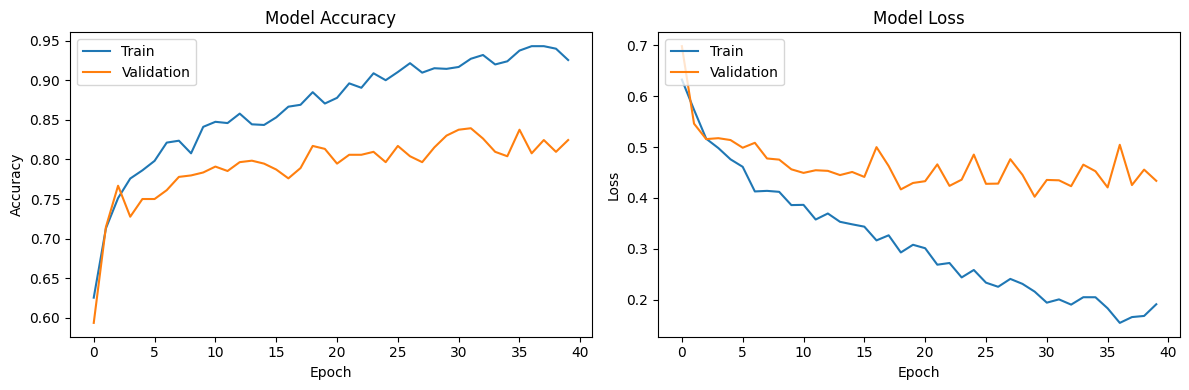

In [3]:
# Visualize training and validation accuracy
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [9]:
# Get predictions and true labels for the validation set
y_val_true = val_generator.classes
y_val_scores = model.predict(val_generator)

# Convert predicted probabilities to binary predictions
y_val_pred = (y_val_scores > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_val_true, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NOCORROSION', 'CORROSION'], yticklabels=['NOCORROSION', 'CORROSION'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_val_true, y_val_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

InvalidArgumentError: Graph execution error:

Detected at node sequential/dense/Relu defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/traitlets/config/application.py", line 1046, in launch_instance

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 736, in start

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 505, in process_one

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 740, in execute_request

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 546, in run_cell

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3024, in run_cell

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3079, in _run_cell

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3284, in run_cell_async

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3466, in run_ast_nodes

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code

  File "/tmp/ipykernel_4443/622204770.py", line 3, in <module>

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 2655, in predict

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 2440, in predict_function

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 2425, in step_function

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 2413, in run_step

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 2381, in predict_step

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 590, in __call__

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/keras/src/engine/sequential.py", line 398, in call

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py", line 255, in call

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/keras/src/activations.py", line 306, in relu

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/keras/src/backend.py", line 5395, in relu

Matrix size-incompatible: In[0]: [32,32768], In[1]: [25088,128]
	 [[{{node sequential/dense/Relu}}]] [Op:__inference_predict_function_4693]

In [5]:
model.save('model1.h5')

/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [15]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Set the path to your dataset
data_dir = './resize_data'

# Define image dimensions and batch size
img_height, img_width = 256, 256
batch_size = 32

# Create ImageDataGenerator for data augmentation and normalization
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.3  # 70% training, 20% validation, 10% testing
)

# Create training dataset
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

# Create validation dataset
val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

# CNN model
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.5))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))


model.add(Flatten())
        
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs = 40,
    validation_data = val_generator,
    verbose = 1
)

# Evaluate the model on the entire validation set
val_loss, val_acc = model.evaluate(val_generator, 
                                   steps=val_generator.samples // batch_size)
print(f'Validation Accuracy: {val_acc * 100:.2f}%')

Found 1254 images belonging to 2 classes.


Found 536 images belonging to 2 classes.
Epoch 1/40
40/40 [==============================] - 47s 1s/step - loss: 0.6999 - accuracy: 0.5016 - val_loss: 0.6910 - val_accuracy: 0.5410
Epoch 2/40
40/40 [==============================] - 44s 1s/step - loss: 0.6862 - accuracy: 0.5526 - val_loss: 0.6881 - val_accuracy: 0.5429
Epoch 3/40
40/40 [==============================] - 45s 1s/step - loss: 0.6690 - accuracy: 0.6021 - val_loss: 0.6676 - val_accuracy: 0.5784
Epoch 4/40
40/40 [==============================] - 46s 1s/step - loss: 0.6326 - accuracy: 0.6691 - val_loss: 0.6410 - val_accuracy: 0.7108
Epoch 5/40
40/40 [==============================] - 47s 1s/step - loss: 0.6004 - accuracy: 0.7145 - val_loss: 0.6177 - val_accuracy: 0.7295
Epoch 6/40
40/40 [==============================] - 46s 1s/step - loss: 0.5998 - accuracy: 0.6930 - val_loss: 0.6270 - val_accuracy: 0.7388
Epoch 7/40
40/40 [==============================] - 44s 1s/step - loss: 0.5769 - accuracy: 0.7273 - val_loss: 0.6089 - 

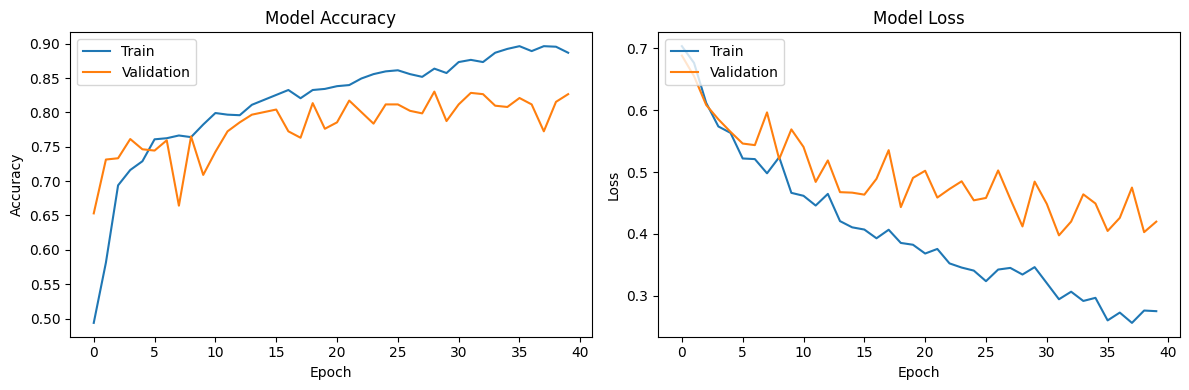

In [13]:
# Visualize training and validation accuracy
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [14]:
model.save('82_model2.h5')

/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [21]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Set the path to your dataset
data_dir = './resize_data'

# Define image dimensions and batch size
img_height, img_width = 256, 256
batch_size = 32

# Create ImageDataGenerator for data augmentation and normalization
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.3  # 70% training, 20% validation, 10% testing
)

# Create training dataset
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    seed=42
)

# Create validation dataset
val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    seed=42
)

# CNN model
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.5))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))


model.add(Flatten())
        
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs = 50,
    validation_data = val_generator,
    verbose = 1
)

# Evaluate the model on the entire validation set
val_loss, val_acc = model.evaluate(val_generator, 
                                   steps=val_generator.samples // batch_size)
print(f'Validation Accuracy: {val_acc * 100:.2f}%')

Found 1254 images belonging to 2 classes.
Found 536 images belonging to 2 classes.


Epoch 1/50
40/40 [==============================] - 60s 1s/step - loss: 0.7063 - accuracy: 0.5207 - val_loss: 0.6745 - val_accuracy: 0.6810
Epoch 2/50
40/40 [==============================] - 60s 2s/step - loss: 0.6306 - accuracy: 0.6746 - val_loss: 0.6347 - val_accuracy: 0.6847
Epoch 3/50
40/40 [==============================] - 60s 2s/step - loss: 0.5936 - accuracy: 0.6986 - val_loss: 0.6145 - val_accuracy: 0.7369
Epoch 4/50
40/40 [==============================] - 61s 2s/step - loss: 0.5627 - accuracy: 0.7281 - val_loss: 0.5847 - val_accuracy: 0.7500
Epoch 5/50
40/40 [==============================] - 60s 2s/step - loss: 0.5257 - accuracy: 0.7632 - val_loss: 0.5494 - val_accuracy: 0.7668
Epoch 6/50
40/40 [==============================] - 61s 2s/step - loss: 0.4965 - accuracy: 0.7727 - val_loss: 0.5453 - val_accuracy: 0.7500
Epoch 7/50
40/40 [==============================] - 60s 2s/step - loss: 0.4878 - accuracy: 0.7767 - val_loss: 0.5506 - val_accuracy: 0.7537
Epoch 8/50
40/40 [==

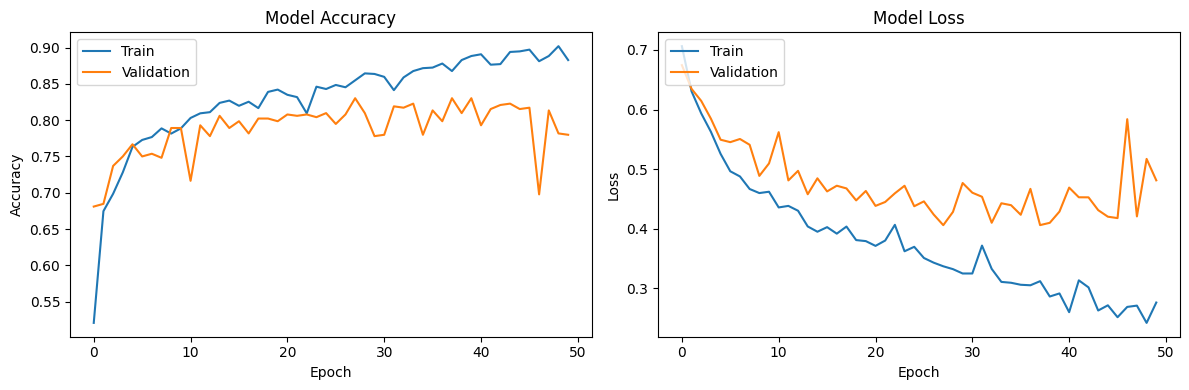

In [22]:
# Visualize training and validation accuracy
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [23]:
model.save('76_model3.h5')

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Set the path to your dataset
data_dir = './resize_data'

# Define image dimensions and batch size
img_height, img_width = 256, 256
batch_size = 32

# Create ImageDataGenerator for data augmentation and normalization
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.3  # 70% training, 20% validation, 10% testing
)

# Create training dataset
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    seed=42
)

# Create validation dataset
val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    seed=42
)

# CNN model
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.5))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))


model.add(Flatten())
        
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs = 20,
    validation_data = val_generator,
    verbose = 1
)

# Evaluate the model on the entire validation set
val_loss, val_acc = model.evaluate(val_generator, 
                                   steps=val_generator.samples // batch_size)
print(f'Validation Accuracy: {val_acc * 100:.2f}%')

Found 1254 images belonging to 2 classes.
Found 536 images belonging to 2 classes.


2023-11-22 23:35:32.557393: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-22 23:35:32.573384: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/20
40/40 [==============================] - 63s 2s/step - loss: 0.6811 - accuracy: 0.5646 - val_loss: 0.6565 - val_accuracy: 0.6437
Epoch 2/20
40/40 [==============================] - 60s 1s/step - loss: 0.6116 - accuracy: 0.7033 - val_loss: 0.6123 - val_accuracy: 0.7201
Epoch 3/20
40/40 [==============================] - 60s 1s/step - loss: 0.5730 - accuracy: 0.7217 - val_loss: 0.5743 - val_accuracy: 0.7556
Epoch 4/20
40/40 [==============================] - 61s 2s/step - loss: 0.5431 - accuracy: 0.7472 - val_loss: 0.5575 - val_accuracy: 0.7575
Epoch 5/20
40/40 [==============================] - 61s 2s/step - loss: 0.5174 - accuracy: 0.7584 - val_loss: 0.5356 - val_accuracy: 0.7425
Epoch 6/20
40/40 [==============================] - 60s 2s/step - loss: 0.4967 - accuracy: 0.7759 - val_loss: 0.5098 - val_accuracy: 0.7761
Epoch 7/20
40/40 [==============================] - 60s 1s/step - loss: 0.4799 - accuracy: 0.7783 - val_loss: 0.4917 - val_accuracy: 0.7854
Epoch 8/20
40/40 [==

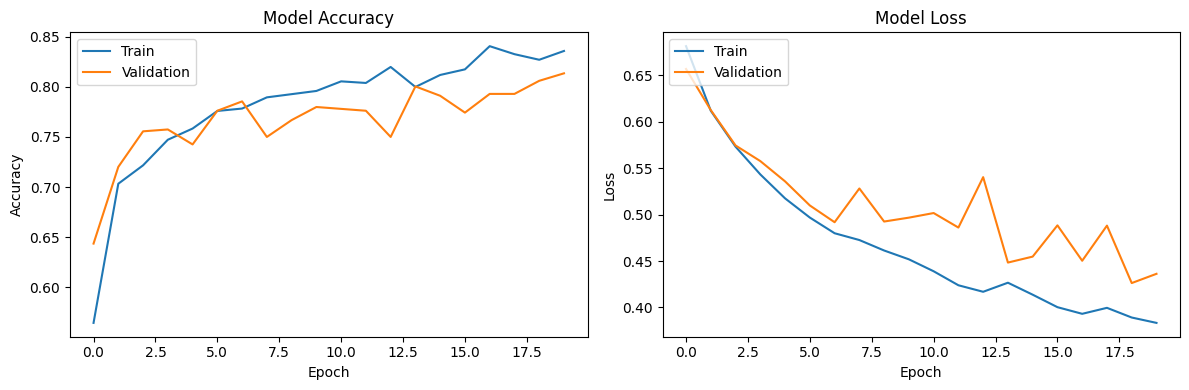

In [3]:
# Visualize training and validation accuracy
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [4]:
model.save('81_model3.h5')

/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [15]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Set the path to your dataset
data_dir = './resize_data'

# Define image dimensions and batch size
img_height, img_width = 256, 256
batch_size = 32

# Create ImageDataGenerator for data augmentation and normalization
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.3  # 70% training, 20% validation, 10% testing
)

# Create training dataset
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    seed=42
)

# Create validation dataset
val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    seed=42
)

# CNN model
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.5))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))


model.add(Flatten())
        
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs = 40,
    validation_data = val_generator,
    verbose = 1
)

# Evaluate the model on the entire validation set
val_loss, val_acc = model.evaluate(val_generator, 
                                   steps=val_generator.samples // batch_size)
print(f'Validation Accuracy: {val_acc * 100:.2f}%')

Found 1254 images belonging to 2 classes.


Found 536 images belonging to 2 classes.
Epoch 1/40
40/40 [==============================] - 58s 1s/step - loss: 0.6988 - accuracy: 0.5494 - val_loss: 0.6823 - val_accuracy: 0.6623
Epoch 2/40
40/40 [==============================] - 56s 1s/step - loss: 0.6341 - accuracy: 0.6906 - val_loss: 0.6248 - val_accuracy: 0.7239
Epoch 3/40
40/40 [==============================] - 56s 1s/step - loss: 0.5808 - accuracy: 0.7153 - val_loss: 0.5935 - val_accuracy: 0.7481
Epoch 4/40
40/40 [==============================] - 58s 1s/step - loss: 0.5432 - accuracy: 0.7416 - val_loss: 0.5719 - val_accuracy: 0.7519
Epoch 5/40
40/40 [==============================] - 58s 1s/step - loss: 0.5230 - accuracy: 0.7584 - val_loss: 0.5451 - val_accuracy: 0.7593
Epoch 6/40
40/40 [==============================] - 58s 1s/step - loss: 0.5217 - accuracy: 0.7496 - val_loss: 0.5245 - val_accuracy: 0.7724
Epoch 7/40
40/40 [==============================] - 60s 1s/step - loss: 0.4915 - accuracy: 0.7783 - val_loss: 0.5289 - 

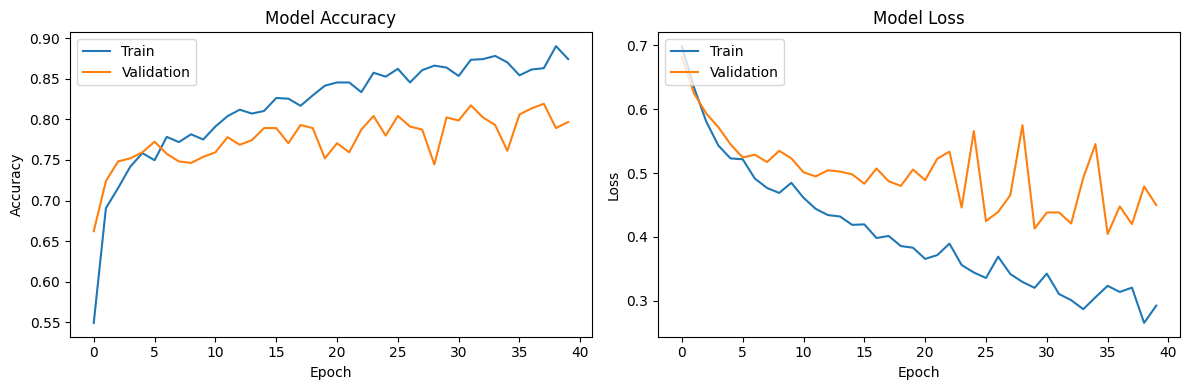

In [16]:
# Visualize training and validation accuracy
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [17]:
model.save('n_85_model3.h5')

/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models

# Set the path to your dataset
data_dir = './resize_data'

# Define image dimensions and batch size
img_height, img_width = 224, 224
batch_size = 32

# Create ImageDataGenerator for data augmentation and normalization
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.3  # 70% training, 20% validation, 10% testing
)

# Create training dataset
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    seed=42
)

# Create validation dataset
val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    seed=42
)

# Load pre-trained VGG16 model with ImageNet weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Build a new model on top of VGG16
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size
)

Found 1254 images belonging to 2 classes.


Found 536 images belonging to 2 classes.


2023-11-23 10:40:45.867768: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-23 10:40:45.887604: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


58889256/58889256 [==============================] - 1046s 18us/step
Epoch 1/10
39/39 [==============================] - 178s 5s/step - loss: 1.0764 - accuracy: 0.6817 - val_loss: 0.4310 - val_accuracy: 0.7988
Epoch 2/10
39/39 [==============================] - 175s 5s/step - loss: 0.3944 - accuracy: 0.8216 - val_loss: 0.4688 - val_accuracy: 0.7812
Epoch 3/10
39/39 [==============================] - 169s 4s/step - loss: 0.3435 - accuracy: 0.8535 - val_loss: 0.3552 - val_accuracy: 0.8574
Epoch 4/10
39/39 [==============================] - 170s 4s/step - loss: 0.3316 - accuracy: 0.8560 - val_loss: 0.3243 - val_accuracy: 0.8613
Epoch 5/10
39/39 [==============================] - 168s 4s/step - loss: 0.2934 - accuracy: 0.8781 - val_loss: 0.3217 - val_accuracy: 0.8535
Epoch 6/10
39/39 [==============================] - 168s 4s/step - loss: 0.2487 - accuracy: 0.8977 - val_loss: 0.3155 - val_accuracy: 0.8496
Epoch 7/10
39/39 [==============================] - 173s 4s/step - loss: 0.2153 - acc

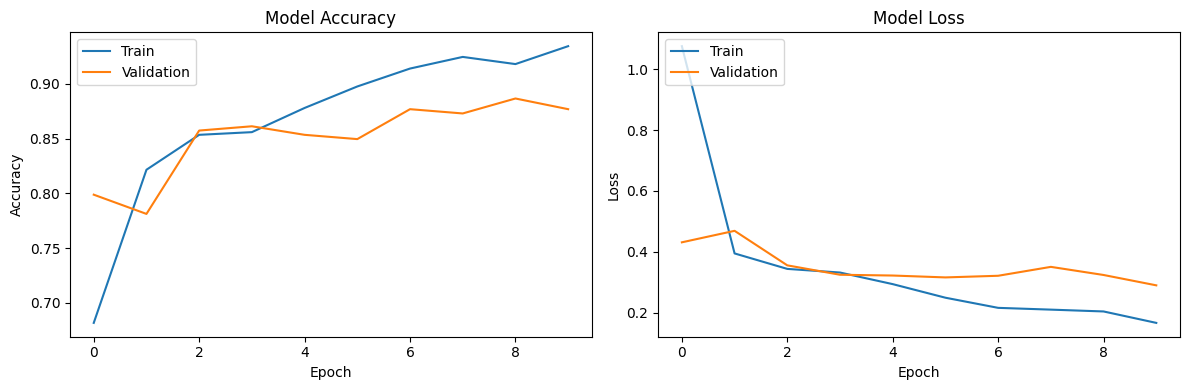

In [3]:
# Visualize training and validation accuracy
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
model.save('81_model3.h5')

/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
